In [1]:
#IMPORTING THE NECESSARY LIBRARIES

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [2]:
#CONNECTING DATASET WITH CODE
import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='h1FPcWHr9FB2AeQQJsj776i_eopbZe6FfyOzYsA2PF2j',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us.cloud-object-storage.appdomain.cloud')

bucket = 'naturaldisasterintensityanalysisa-donotdelete-pr-pwiuxy2i5hirv2'
object_key = 'Cyclone_Wildfire_Flood_Earthquake_Database.zip'

streaming_body_2 = cos_client.get_object(Bucket=bucket, Key=object_key)['Body']

# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about the possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/


In [3]:
#EXTRACTING THE DATASET USING BytesIO unzip function
from io import BytesIO
import zipfile
unzip=zipfile.ZipFile(BytesIO(streaming_body_2.read()),'r')
file_paths=unzip.namelist()
for path in file_paths:
    unzip.extract(path)

In [4]:
ls

Cyclone_Wildfire_Flood_Earthquake_Database/


In [5]:
pwd

'/home/wsuser/work'

In [6]:
dir=r'/home/wsuser/work/Cyclone_Wildfire_Flood_Earthquake_Database'
#CONFIGURING THE ImageDataGenerator CLASS
train_datagen=ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen=ImageDataGenerator(rescale=1./255)

In [7]:
#LISTING OUT THE DISASTER CLASSES
for i in os.listdir(dir):
    print(i)

Flood
Earthquake
Wildfire
Cyclone
readme.txt


In [8]:
path=os.path.join(dir,'readme.txt')
os.remove(path)

In [9]:
for i in os.listdir(dir):
    print(i)

Flood
Earthquake
Wildfire
Cyclone


In [10]:
pip install split_folders

Note: you may need to restart the kernel to use updated packages.


In [11]:
#SPLIT THE DATASET INTO TRAINING, TESTING AND VALIDATION DATA
import splitfolders
splitfolders.ratio(dir,output="dataset",seed=42,ratio=(.7,.2,.1),group_prefix=None)

Copying files: 4428 files [00:02, 1809.64 files/s]


In [12]:
for i in os.listdir(dir):
    print(i)

Flood
Earthquake
Wildfire
Cyclone


In [13]:
dir1=r'/home/wsuser/work/dataset'

In [14]:
for i in os.listdir(dir1):
    print(i)

train
val
test


In [15]:
#Apply ImageDataGenerator Functionality to Trainset and Testset(Validation Set)
x_train = train_datagen.flow_from_directory(r"/home/wsuser/work/dataset/train",
                                            target_size=(299,299),
                                            batch_size=10,
                                            color_mode='rgb',
                                            class_mode='categorical')
x_val=test_datagen.flow_from_directory(r"/home/wsuser/work/dataset/val",
                                        target_size=(299,299),
                                        batch_size=10,
                                        color_mode='rgb',
                                        class_mode='categorical')

Found 3097 images belonging to 4 classes.
Found 884 images belonging to 4 classes.


In [16]:
#70% of images goes to training, #20% of the total to validation, and #10% remaining goes to testing data
x_test=test_datagen.flow_from_directory(r"/home/wsuser/work/dataset/test")
                                        

Found 447 images belonging to 4 classes.


In [17]:
#Classes of Disasters
x_train.class_indices

{'Cyclone': 0, 'Earthquake': 1, 'Flood': 2, 'Wildfire': 3}

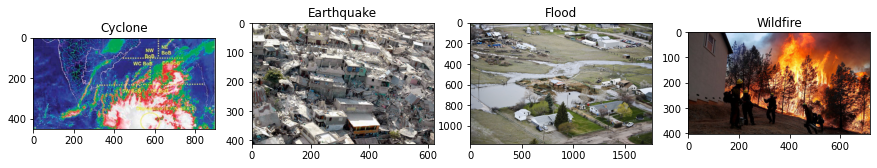

In [18]:
#Sample Plot for each of the Classes
from skimage import io
f=['/home/wsuser/work/dataset/train/Cyclone/1.jpg','/home/wsuser/work/dataset/train/Earthquake/0.jpg','/home/wsuser/work/dataset/train/Flood/2.jpg','/home/wsuser/work/dataset/train/Wildfire/3.jpg']
class_names=['Cyclone', 'Earthquake', 'Flood', 'Wildfire']
x, axarr = plt.subplots(1,4,figsize=(15,15))
for i in range(4):
  axarr[i].imshow(io.imread(f[i]))
  axarr[i].title.set_text(class_names[i])


## Building the CNN Sequential Model

In [19]:
model=Sequential()

In [20]:
#Input Convolution Layer
model.add(Convolution2D(32,kernel_size=(3,3),input_shape=(299,299,3),strides=(1,1),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#Convolution Layer 2
model.add(Convolution2D(64,kernel_size=(3,3),input_shape=(299,299,3),strides=(1,1),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
#Convolution Layer 3
model.add(Convolution2D(32,kernel_size=(3,3),input_shape=(299,299,3),strides=(1,1),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
#Flattening of Output
model.add(Flatten())
#FCN or Dense Layer
model.add(Dense(units=256,kernel_initializer="random_uniform",activation="relu"))
model.add(Dropout(0.4))
#Output Layer
model.add(Dense(units=4,activation="softmax"))

In [21]:
#Summary of the Model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 297, 297, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 148, 148, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 73, 73, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 32)        1

In [22]:
#Compiling the Model
model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

In [23]:
#Model Fitting - training and validation
history=model.fit_generator(x_train,steps_per_epoch=len(x_train),epochs=30,validation_data=x_val,validation_steps=len(x_val))
#steps_per_epoch = no of train images/batch size
#validation_steps = no of test images/batch size

Epoch 1/30
310/310 [==============================] - 594s 2s/step - loss: 1.1061 - accuracy: 0.5211 - val_loss: 0.7476 - val_accuracy: 0.7692
Epoch 2/30
310/310 [==============================] - 582s 2s/step - loss: 0.6838 - accuracy: 0.7501 - val_loss: 0.5879 - val_accuracy: 0.7862
Epoch 3/30
310/310 [==============================] - 587s 2s/step - loss: 0.5659 - accuracy: 0.7963 - val_loss: 0.5280 - val_accuracy: 0.8054
Epoch 4/30
310/310 [==============================] - 586s 2s/step - loss: 0.5320 - accuracy: 0.8053 - val_loss: 0.4945 - val_accuracy: 0.8167
Epoch 5/30
310/310 [==============================] - 589s 2s/step - loss: 0.4719 - accuracy: 0.8273 - val_loss: 0.5247 - val_accuracy: 0.8133
Epoch 6/30
310/310 [==============================] - 589s 2s/step - loss: 0.4326 - accuracy: 0.8418 - val_loss: 0.4233 - val_accuracy: 0.8541
Epoch 7/30
310/310 [==============================] - 581s 2s/step - loss: 0.4571 - accuracy: 0.8411 - val_loss: 0.4577 - val_accuracy: 0.8484

In [24]:
len(x_train)

310

In [25]:
#saving the Model
model.save('Disaster_Classifier.h5')
model_json=model.to_json()
with open("model-bw.json","w") as json_file:
  json_file.write(model_json)

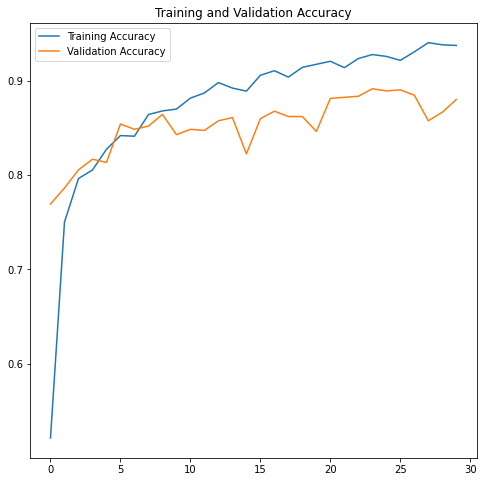

In [27]:
#Training and Validation Accuracy Plots
epochs_range = range(30)

plt.figure(figsize=(8, 8))
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

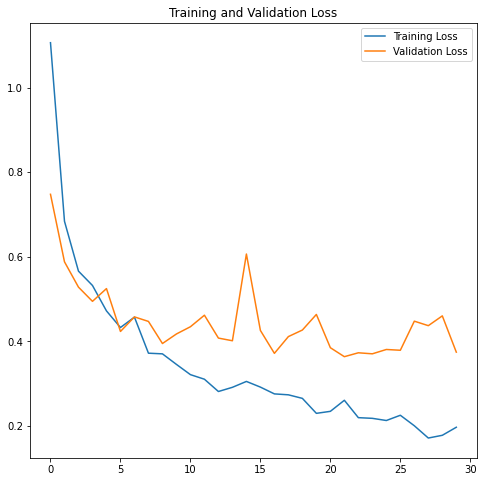

In [28]:
#Training and Validation Loss Plot
plt.figure(figsize=(8, 8))
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [29]:
#Testing the CNN Model with test data
test_generator=test_datagen.flow_from_directory(r"/home/wsuser/work/dataset/test",
                                        target_size=(299,299),
                                        batch_size=447,
                                        color_mode='rgb',
                                        class_mode='categorical')

Found 447 images belonging to 4 classes.


In [30]:
x_test, y_test = test_generator.__getitem__(0)

In [31]:
y_test

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [32]:
#predicting the labels of test data
y_pred = model.predict(x_test)

In [33]:
y_pred = np.argmax(y_pred,axis=1)

In [34]:
y_pred

array([0, 0, 0, 3, 2, 2, 0, 2, 1, 1, 3, 3, 1, 0, 2, 1, 3, 2, 1, 1, 2, 1,
       1, 1, 3, 1, 1, 1, 3, 1, 1, 2, 0, 1, 2, 1, 2, 1, 0, 2, 2, 1, 2, 1,
       0, 3, 1, 0, 2, 1, 1, 1, 0, 2, 1, 1, 0, 1, 2, 3, 1, 3, 3, 3, 2, 1,
       0, 2, 1, 3, 1, 3, 2, 0, 2, 1, 3, 1, 0, 2, 3, 1, 1, 3, 3, 2, 1, 1,
       3, 2, 3, 1, 1, 3, 3, 3, 0, 1, 2, 3, 0, 2, 2, 0, 3, 1, 0, 1, 0, 1,
       3, 1, 0, 2, 1, 3, 3, 0, 0, 2, 0, 2, 3, 1, 0, 2, 2, 3, 2, 0, 1, 1,
       0, 0, 1, 3, 0, 2, 2, 2, 3, 0, 3, 3, 2, 1, 2, 3, 0, 3, 2, 3, 2, 2,
       1, 0, 1, 0, 0, 1, 1, 2, 3, 3, 3, 2, 2, 2, 0, 1, 0, 3, 3, 2, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 2, 3, 2, 2, 1, 1, 2, 2, 3, 1, 3, 3, 1,
       0, 1, 1, 1, 2, 2, 1, 0, 2, 2, 2, 3, 1, 2, 3, 0, 2, 3, 1, 3, 2, 1,
       0, 3, 2, 0, 1, 1, 1, 1, 0, 1, 0, 2, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 3, 3, 2, 2, 2, 0, 3, 3, 1, 2, 1, 0, 3, 1, 0, 0, 0, 2, 3, 0, 0,
       3, 1, 2, 1, 1, 2, 0, 3, 0, 3, 2, 1, 3, 3, 3, 1, 1, 0, 3, 1, 0, 2,
       1, 1, 0, 1, 3, 1, 0, 1, 1, 3, 1, 3, 0, 0, 2,

In [35]:
y_test = np.argmax(y_test, axis=1)

In [36]:
y_test

array([0, 0, 0, 3, 2, 2, 0, 2, 1, 3, 3, 3, 0, 0, 2, 1, 3, 2, 1, 1, 2, 1,
       1, 1, 3, 1, 1, 1, 3, 1, 1, 2, 0, 1, 1, 1, 2, 1, 0, 1, 2, 1, 2, 1,
       0, 3, 1, 0, 2, 1, 1, 1, 0, 2, 1, 1, 3, 1, 2, 3, 1, 3, 3, 3, 2, 1,
       0, 2, 1, 3, 1, 3, 2, 0, 2, 1, 3, 1, 0, 2, 3, 2, 1, 3, 3, 2, 1, 3,
       3, 1, 2, 1, 1, 3, 3, 0, 0, 0, 2, 3, 0, 2, 2, 0, 0, 1, 0, 1, 0, 1,
       3, 1, 0, 2, 1, 3, 3, 0, 0, 2, 0, 2, 3, 1, 0, 2, 2, 3, 3, 0, 1, 1,
       0, 0, 1, 3, 0, 2, 3, 2, 3, 0, 3, 3, 2, 1, 2, 3, 0, 3, 2, 3, 2, 2,
       1, 0, 1, 0, 0, 1, 1, 2, 3, 3, 1, 2, 3, 2, 0, 1, 0, 3, 3, 2, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 2, 3, 2, 3, 1, 1, 2, 2, 3, 2, 3, 3, 2,
       2, 1, 1, 2, 2, 3, 1, 0, 2, 2, 2, 3, 1, 2, 3, 0, 2, 1, 1, 2, 3, 1,
       0, 2, 2, 0, 1, 1, 1, 1, 0, 1, 0, 2, 1, 2, 1, 2, 1, 1, 2, 1, 0, 1,
       0, 3, 3, 2, 2, 2, 0, 3, 3, 1, 2, 1, 0, 3, 1, 0, 0, 0, 2, 3, 0, 0,
       3, 1, 3, 0, 1, 2, 0, 1, 0, 3, 2, 1, 3, 3, 3, 1, 1, 0, 1, 1, 0, 2,
       1, 1, 0, 1, 3, 1, 0, 1, 1, 3, 2, 3, 0, 0, 2,

In [37]:
import keras.backend as K
def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    return K.mean(K.equal(y_true, K.round(y_pred)))

In [38]:
#Classification report with Accuracy (F1 Score) for each Class
print("CNN Disaster Classification Model Accuracy on test set: {:.4f}".format(accuracy(y_test, y_pred)))
print(classification_report(y_test, y_pred))

CNN Disaster Classification Model Accuracy on test set: 0.8881
              precision    recall  f1-score   support

           0       0.96      0.90      0.93        94
           1       0.86      0.92      0.89       136
           2       0.87      0.84      0.85       108
           3       0.90      0.88      0.89       109

    accuracy                           0.89       447
   macro avg       0.89      0.89      0.89       447
weighted avg       0.89      0.89      0.89       447



In [40]:
#Weighted Accuracy of the model
accu = np.count_nonzero(np.equal(y_pred,y_test))/x_test.shape[0]
print("Accuracy: {} %".format(accu*100))

Accuracy: 88.81431767337807 %


In [41]:
classes = list(x_train.class_indices.keys())

<AxesSubplot:>

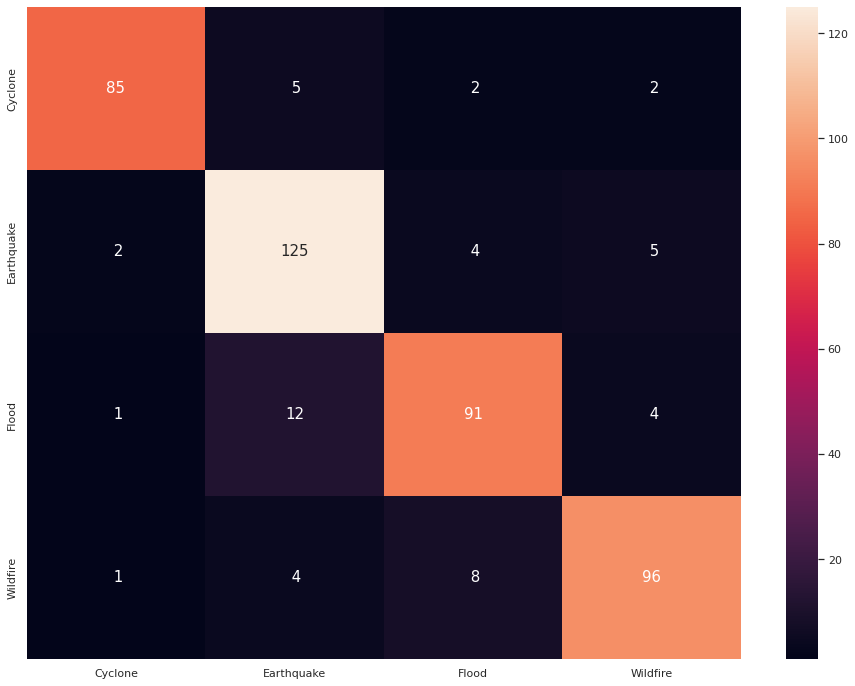

In [42]:
#Confusion matrix for test data Classification
import pandas as pd
df_cmatrix = pd.DataFrame(confusion_matrix(y_test, y_pred),index=classes, columns=classes)
sns.set(font_scale=1.0)
fig,ax = plt.subplots(figsize=(16,12))
sns.heatmap(df_cmatrix, annot=True,annot_kws={"size": 15},fmt='2g')

In [43]:
!pip install watson-machine-learning-client

     |████████████████████████████████| 538 kB 14.5 MB/s eta 0:00:01


In [44]:
from ibm_watson_machine_learning import APIClient
wml_credentials={
    "url":"https://us-south.ml.cloud.ibm.com",
    "apikey":"FL50oXnyvJpeQux8ESsd62D07JUi6ykvFqatOBUiidZE"
}

client=APIClient(wml_credentials)

In [56]:
def guid_space_name(client,natural_disaster_classification_final):
    space=client.spaces.get_details()
    return(next(item for item in space['resources'] if item['entity']['name']==natural_disaster_classification_final)['metadata']['id'])

In [58]:
space_uid=guid_space_name(client,'natural_disaster_classification_final')
print("Space UID "+space_uid)

Space UID 621753f2-d362-44f0-ad75-70ca294a0245


In [59]:
client.set.default_space(space_uid)

'SUCCESS'

In [60]:
software_space_uid=client.software_specifications.get_uid_by_name('tensorflow_rt22.1-py3.9')

In [61]:
!tar -zcvf natural-disaster-classification-final-model.tgz  Disaster_Classifier.h5

Disaster_Classifier.h5


In [62]:
model_details=client.repository.store_model(model='natural-disaster-classification-final-model.tgz',meta_props={
    client.repository.ModelMetaNames.NAME:"CNN Model Building",
    client.repository.ModelMetaNames.TYPE:'tensorflow_2.7',
    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID:software_space_uid
})

In [63]:
model_id=client.repository.get_model_id(model_details)

In [65]:
client.repository.download(model_id,'natural-disaster_final.tar.gb')

Successfully saved model content to file: 'natural-disaster_final.tar.gb'


'/home/wsuser/work/natural-disaster_final.tar.gb'